In [6]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim.models import Word2Vec
import gensim
import warnings
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import tensorflow as tf
from keras import layers
from keras.layers import Bidirectional

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import normalize
from sklearn.model_selection import RandomizedSearchCV

import numpy as np
import pandas as pd
import tensorflow as tf
# from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [25]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samma\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samma\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\samma\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv('./tweet_emotions.csv')

In [4]:
df.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [5]:
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df = df.replace(to_replace=r'[^\w\s]', value='', regex=True)
df = df.replace(to_replace=r'\d', value='', regex=True)

In [6]:

df['content'] = df['content'].apply(word_tokenize)

In [7]:
print(df['content'])

0        [tiffanylue, i, know, i, was, listenin, to, ba...
1        [layin, n, bed, with, a, headache, ughhhhwaiti...
2                        [funeral, ceremonygloomy, friday]
3              [wants, to, hang, out, with, friends, soon]
4        [dannycastillo, we, want, to, trade, with, som...
                               ...                        
39995                                    [johnlloydtaylor]
39996                 [happy, mothers, day, all, my, love]
39997    [happy, mothers, day, to, all, the, mommies, o...
39998    [niariley, wassup, beautiful, follow, me, peep...
39999    [mopedronin, bullet, train, from, tokyo, the, ...
Name: content, Length: 40000, dtype: object


In [8]:
stop_words = set(stopwords.words('english'))
df['content'] = df['content'].apply(lambda x: [word for word in x if word not in stop_words])
print(df['content'])

0        [tiffanylue, know, listenin, bad, habit, earli...
1            [layin, n, bed, headache, ughhhhwaitin, call]
2                        [funeral, ceremonygloomy, friday]
3                             [wants, hang, friends, soon]
4        [dannycastillo, want, trade, someone, houston,...
                               ...                        
39995                                    [johnlloydtaylor]
39996                          [happy, mothers, day, love]
39997    [happy, mothers, day, mommies, woman, man, lon...
39998    [niariley, wassup, beautiful, follow, peep, ne...
39999    [mopedronin, bullet, train, tokyo, gf, visitin...
Name: content, Length: 40000, dtype: object


In [9]:

# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# define function to lemmatize tokens
def lemmatize_tokens(tokens):
    # convert POS tag to WordNet format
    def get_wordnet_pos(word):
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
        return tag_dict.get(tag, wordnet.NOUN)
    
    # lemmatize tokens
    lemmas = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]
    
    # return lemmatized tokens as a list
    return lemmas

# apply lemmatization function to column of dataframe
df['lemmatized_messages'] = df['content'].apply(lemmatize_tokens)

In [10]:
print(df['lemmatized_messages'])

0        [tiffanylue, know, listenin, bad, habit, earli...
1            [layin, n, bed, headache, ughhhhwaitin, call]
2                        [funeral, ceremonygloomy, friday]
3                               [want, hang, friend, soon]
4        [dannycastillo, want, trade, someone, houston,...
                               ...                        
39995                                    [johnlloydtaylor]
39996                           [happy, mother, day, love]
39997    [happy, mother, day, mommy, woman, man, long, ...
39998    [niariley, wassup, beautiful, follow, peep, ne...
39999    [mopedronin, bullet, train, tokyo, gf, visit, ...
Name: lemmatized_messages, Length: 40000, dtype: object


In [11]:
#model for word2Vec - word embedding based on relationshi
#between other words in the word list
model1 = gensim.models.Word2Vec(df['content'], min_count=1,
                                vector_size=100, window=5)

In [12]:
print("Cosine similarity between 'friend' " +
      "and 'man' - Skip Gram : ",
      model1.wv.similarity('friend', 'man'))
 
print("Cosine similarity between 'friend' " +
      "and 'funeral' - Skip Gram : ",
      model1.wv.similarity('friend', 'funeral'))

Cosine similarity between 'friend' and 'man' - Skip Gram :  0.9959932
Cosine similarity between 'friend' and 'funeral' - Skip Gram :  0.9743547


In [13]:
model2 = gensim.models.Word2Vec(df['lemmatized_messages'], min_count=1, vector_size=100,
                                window=5, sg=1)
 
print("Cosine similarity between 'friend' " +
      "and 'man' - Skip Gram : ",
      model2.wv.similarity('friend', 'man'))
 
print("Cosine similarity between 'friend' " +
      "and 'funeral' - Skip Gram : ",
      model2.wv.similarity('friend', 'funeral'))

Cosine similarity between 'friend' and 'man' - Skip Gram :  0.83785045
Cosine similarity between 'friend' and 'funeral' - Skip Gram :  0.8787193


In [14]:

from nltk.corpus import wordnet
import random

# Ensure WordNet is downloaded
import nltk
nltk.download('wordnet')

def get_synonyms(word):
    # Retrieve all synonyms for the word
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            # Avoid adding the original word as a synonym
            if lemma.name().lower() != word.lower():
                synonyms.add(lemma.name().replace('_', ' '))
                
    # Return a list of synonyms if available, else return an empty list
    return list(synonyms)

def synonym_replacement(sentence):
    new_sentence = []
    for word in sentence:
        synonyms = get_synonyms(word)  # You'd need to implement `get_synonyms`
        new_sentence.append(random.choice(synonyms) if synonyms else word)
    return new_sentence

df['augmented_content'] = df['content'].apply(synonym_replacement)




# Testing get_synonyms
print(get_synonyms("happy"))  # Example test



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['glad', 'well-chosen', 'felicitous']


In [15]:
friend_vector = model2.wv['friend']
print("Vector for the word 'friend':\n", friend_vector)

Vector for the word 'friend':
 [-0.14579137  0.22831209 -0.05666328 -0.19438118 -0.11369746 -0.7109064
  0.10570696  1.0578622  -0.14525785 -0.41415933  0.1073328  -0.47665036
  0.29943824  0.20834991 -0.02117762  0.02799847 -0.06982782 -0.41148758
 -0.18595128 -0.78896475  0.04959619  0.01982373  0.18832444 -0.00463126
 -0.18342097 -0.1001075  -0.33708006 -0.41703188 -0.2928391  -0.1830739
  0.18927556  0.06367359  0.17820333 -0.61139023 -0.26790988  0.44485593
  0.13744906 -0.4107825  -0.25680995 -0.83938205 -0.05505989 -0.16884741
 -0.08582123 -0.06418086  0.21716869 -0.3912916  -0.516619   -0.45504826
  0.18649235  0.40923938  0.14760178 -0.44934943 -0.2869737  -0.19808532
  0.2290338  -0.01375534  0.73076856 -0.12882811 -0.26067382  0.32222018
 -0.09901069  0.05876405  0.14425738  0.00964581 -0.62670887  0.6309199
  0.54042286  0.34324154 -0.65207916  0.59441304 -0.2719991  -0.05522281
  0.5172338   0.13236761  0.95953053  0.49804044  0.03323397  0.13626236
 -0.71807665  0.2949269

C:\Users\samma\AppData\Local\Temp\ipykernel_13904\3636274052.py:20: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]), textcoords='offset points', ha='center', va='center', fontsize=8)


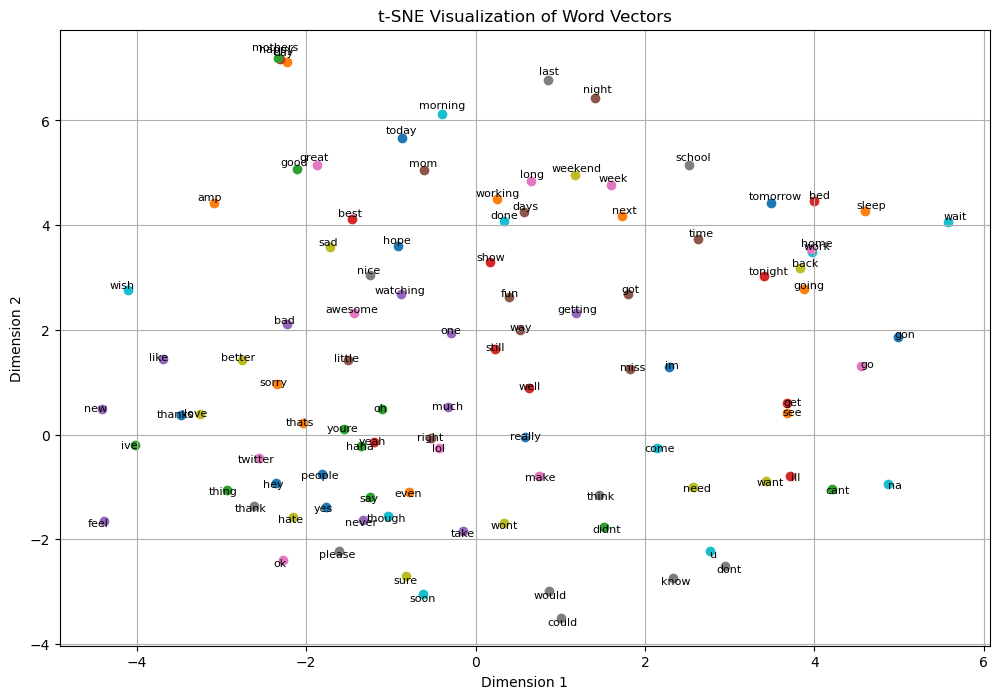

In [16]:

# plotting vector using dimension reduction techniques


# Select the words you want to visualize
words = list(model1.wv.index_to_key)  # List of all words in the model1
# For example, you might want to visualize the top 100 words
words_to_visualize = words[:100]  

# Extract the corresponding vectors
word_vectors = np.array([model1.wv[word] for word in words_to_visualize])

# Dimensionality reduction using t-SNE
tsne = TSNE(n_components=2, random_state=0)
reduced_vectors = tsne.fit_transform(word_vectors)

# Plotting
plt.figure(figsize=(12, 8))
for i, word in enumerate(words_to_visualize):
    plt.scatter(reduced_vectors[i, 0], reduced_vectors[i, 1])
    plt.annotate(word, xy=(reduced_vectors[i, 0], reduced_vectors[i, 1]), textcoords='offset points', ha='center', va='center', fontsize=8)

plt.title("t-SNE Visualization of Word Vectors")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid()
plt.show()

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['lemmatized_messages'])
X_sequences = tokenizer.texts_to_sequences(df['lemmatized_messages'])
X_padded = pad_sequences(X_sequences, maxlen=100)  # Adjust maxlen as needed

# Step 2: Encode the target labels (assuming each sentiment is a list)
# Convert the target emotions into a multi-hot encoded format
y = pd.get_dummies(df['sentiment'].apply(pd.Series).stack()).sum(level=0)

# Step 3: Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

C:\Users\samma\AppData\Local\Temp\ipykernel_13904\4292409634.py:8: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  y = pd.get_dummies(df['sentiment'].apply(pd.Series).stack()).sum(level=0)


In [54]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['lemmatized_messages'])
X_sequences = tokenizer.texts_to_sequences(df['lemmatized_messages'])
X_padded = pad_sequences(X_sequences, maxlen=100)

# Encode the target labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(df['sentiment'])
Y_one_hot = to_categorical(Y_encoded)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y_one_hot, test_size=0.2, random_state=42)

# Define the model architecture
def create_model(gru_units=16, dense_units=16, dropout_rate=0.5):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=100))
    model.add(Bidirectional(GRU(gru_units, return_sequences=True, kernel_regularizer=l2(0.002))))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(GRU(gru_units, kernel_regularizer=l2(0.002)))) 
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(0.003)))
    model.add(BatchNormalization())
    model.add(Dense(Y_one_hot.shape[1], activation='softmax'))
    optimizer = Adam(learning_rate=0.0001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Create and train the model
model = create_model()
history = model.fit(X_train, Y_train, epochs=15, batch_size=32, validation_data=(X_test, Y_test), callbacks=[early_stopping])

Epoch 1/15


c:\Users\samma\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 102s 95ms/step - accuracy: 0.0960 - loss: 2.9733 - val_accuracy: 0.2176 - val_loss: 2.6743
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - accuracy: 0.2116 - loss: 2.6045 - val_accuracy: 0.2477 - val_loss: 2.3956
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 91s 91ms/step - accuracy: 0.2514 - loss: 2.3350 - val_accuracy: 0.3050 - val_loss: 2.2220
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 90s 90ms/step - accuracy: 0.3260 - loss: 2.1484 - val_accuracy: 0.3187 - val_loss: 2.1424
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 92s 92ms/step - accuracy: 0.3802 - loss: 1.9934 - val_accuracy: 0.3164 - val_loss: 2.1331
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - accuracy: 0.4337 - loss: 1.8268 - val_accuracy: 0.3075 - val_loss: 2.1953
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 101s 101ms/step - accuracy: 0.4818 - loss: 1.6917 - val_accuracy: 0.3061 - val_loss: 2.2591


In [31]:
# Step 1: Preprocess your data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['lemmatized_messages'])
X_sequences = tokenizer.texts_to_sequences(df['lemmatized_messages'])

# Pad the sequences so that all inputs are the same length
X_padded = pad_sequences(X_sequences, maxlen=100)  # Adjust maxlen based on your data

# Step 2: Encode your target labels
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(df['sentiment'])  # Replace 'sentiment' with your actual target column name

# Convert to one-hot encoding (if your labels are not already in one-hot form)
Y_one_hot = to_categorical(Y_encoded)

# Step 3: Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_padded, Y_one_hot, test_size=0.2, random_state=42)

X_train_normalized = normalize(X_train, axis=0)
X_test_normalized = normalize(X_test, axis=0)
# Function to create LSTM model
# def create_model(lstm_units=128, dense_units=64, dropout_rate=0.5):
#     model = Sequential()
#     model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=100))  # Embedding layer
#     model.add(LSTM(lstm_units))  # LSTM layer
#     model.add(Dropout(dropout_rate))  # Dropout layer
#     model.add(Dense(dense_units, activation='relu'))  # Fully connected layer
#     model.add(Dense(Y_one_hot.shape[1], activation='softmax'))  # Output layer for multi-class classification

#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# Function to create the LSTM model
def create_model(lstm_units=128, dense_units=64, dropout_rate=0.5, l2_reg=0.01):
    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=100))  
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(lstm_units, kernel_regularizer=l2(l2_reg))))  
    
    # Dropout layer
    model.add(Dropout(dropout_rate))  
    
    # Fully connected layer with L2 regularization
    model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_reg)))  
    
    # Batch Normalization
    model.add(BatchNormalization())
    
    # Output layer for multi-class classification
    model.add(Dense(Y_one_hot.shape[1], activation='softmax'))  
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create model
model = create_model()

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Fit model with early stopping
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test), callbacks=[early_stopping])

# Evaluate model
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

c:\Users\samma\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 172s 166ms/step - accuracy: 0.2558 - loss: 3.1331 - val_accuracy: 0.3385 - val_loss: 1.9812
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 119s 119ms/step - accuracy: 0.4231 - loss: 1.7802 - val_accuracy: 0.3248 - val_loss: 2.0799
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 111s 111ms/step - accuracy: 0.5603 - loss: 1.4160 - val_accuracy: 0.2697 - val_loss: 2.4080
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 109s 109ms/step - accuracy: 0.6619 - loss: 1.1289 - val_accuracy: 0.2853 - val_loss: 2.7587
Test Accuracy: 33.85%


In [27]:
import numpy as np
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Step 4: Hyperparameter space for tuning (defining ranges)
param_dist = {
    'lstm_units': [64, 128, 256],
    'dense_units': [32, 64, 128],
    'dropout_rate': [0.0, 0.2, 0.5],
    'batch_size': [16, 32, 64],
}

best_accuracy = 0
best_params = {}

# Number of random combinations to try
n_random_search = 20

# Early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Step 5: Random hyperparameter tuning
for _ in range(n_random_search):
    lstm_units = random.choice(param_dist['lstm_units'])
    dense_units = random.choice(param_dist['dense_units'])
    dropout_rate = random.choice(param_dist['dropout_rate'])
    batch_size = random.choice(param_dist['batch_size'])

    print(f"Training with: lstm_units={lstm_units}, dense_units={dense_units}, dropout_rate={dropout_rate}, batch_size={batch_size}")
    
    # Create model
    model = create_model(lstm_units=lstm_units, dense_units=dense_units, dropout_rate=dropout_rate)
    
    # Fit the model with validation data
    history = model.fit(X_train, Y_train, epochs=20, batch_size=batch_size, 
                        validation_data=(X_test, Y_test), 
                        callbacks=[early_stopping], 
                        verbose=0)
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print(f"Accuracy: {accuracy * 100:.2f}%")

    # Update best parameters if current model is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = {
            'lstm_units': lstm_units,
            'dense_units': dense_units,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size
        }

# Step 6: Print best parameters
print("Best parameters found:")
print(best_params)
print(f"Best accuracy is: {best_accuracy * 100:.2f}%")


Training with: lstm_units=128, dense_units=64, dropout_rate=0.2, batch_size=32
Accuracy: 34.34%
Training with: lstm_units=128, dense_units=64, dropout_rate=0.5, batch_size=64
Accuracy: 29.05%
Training with: lstm_units=256, dense_units=128, dropout_rate=0.0, batch_size=16


KeyboardInterrupt: 

In [ ]:
# Step 7: Train the model with the best parameters
best_model = create_model(
    lstm_units=best_params['lstm_units'],
    dense_units=best_params['dense_units'],
    dropout_rate=best_params['dropout_rate']
)

# Fit the model with best parameters
best_model.fit(X_train, Y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_test, Y_test))

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(X_test, Y_test)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")


In [63]:
new_texts = ["I am very happy today!", "This is frustrating and annoying."]  # Example new data

# Tokenize and pad the new text data the same way as training data
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=100)  # Use the same maxlen as used in training

# Step 2: Use the trained model to predict
predictions = model.predict(new_padded)

# Step 3: Convert predictions to class labels
# If you used 'categorical_crossentropy', you'll get probabilities, so use np.argmax to get the class with the highest probability
predicted_classes = np.argmax(predictions, axis=1)

# If you have a mapping of integer classes to their original labels (e.g., 'happy', 'angry', etc.), you can map them back
# Let's assume 'label_encoder' was used to encode the original labels, so we can reverse the encoding
predicted_labels = label_encoder.inverse_transform(predicted_classes)

# Output the predictions
for i, text in enumerate(new_texts):
    print(f"Text: '{text}' - Predicted Emotion: {predicted_labels[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
Text: 'I am very happy today!' - Predicted Emotion: worry
Text: 'This is frustrating and annoying.' - Predicted Emotion: neutral
